In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('数据示例.xlsx',header=None)
df.rename(columns={0:'Date',1:'F1',2:'F2'},inplace=True)
df.set_index('Date',inplace=True)

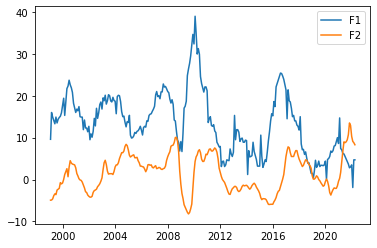

In [3]:
plt.plot(df.F1,label='F1')
plt.plot(df.F2,label='F2')
plt.legend()

指数平滑法有几种不同形式：一次指数平滑法针对没有趋势和季节性的序列，二次指数平滑法针对有趋势但没有季节性的序列，三次指数平滑法针对有趋势也有季节性的序列

In [4]:
from statsmodels.tsa import stattools
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels

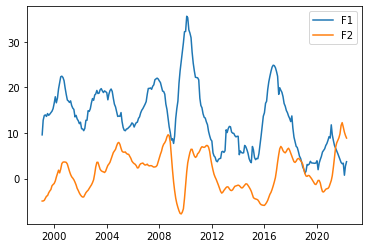

In [5]:
ses1 = SimpleExpSmoothing(np.asarray(df.F1)).fit(smoothing_level=0.5,optimized=False)
ses2 = SimpleExpSmoothing(np.asarray(df.F2)).fit(smoothing_level=0.5,optimized=False)
data = df.copy(deep=True)
data['F1'] = ses1.fittedfcast[1:]
data['F2'] = ses2.fittedfcast[1:]
plt.plot(data.F1,label='F1')
plt.plot(data.F2,label='F2')
plt.legend()

(-1.2196253216950192, 0.6650969348576583, 0, 278, {'1%': -3.4540935579190495, '5%': -2.8719934111688965, '10%': -2.5723401594120388}, 918.2641467310597)
(-1.3587527658465028, 0.6018831593616496, 0, 278, {'1%': -3.4540935579190495, '5%': -2.8719934111688965, '10%': -2.5723401594120388}, 639.9857773056651)
(-11.21283774709, 2.104670349413068e-20, 0, 277, {'1%': -3.4541800885158525, '5%': -2.872031361137725, '10%': -2.5723603999791473}, 865.7148804589594)
(-4.479315700410481, 0.00021427305609132103, 0, 277, {'1%': -3.4541800885158525, '5%': -2.872031361137725, '10%': -2.5723603999791473}, 264.91791722162014)


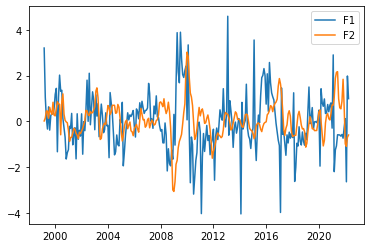

In [6]:
diff_1=data.diff(1)
diff1=diff_1.dropna()
print(stattools.adfuller(data.F1,0))
print(stattools.adfuller(data.F2,0))
print(stattools.adfuller(diff1.F1,0))
print(stattools.adfuller(diff1.F2,0))
plt.plot(diff1.F1,label='F1')
plt.plot(diff1.F2,label='F2')
plt.legend()

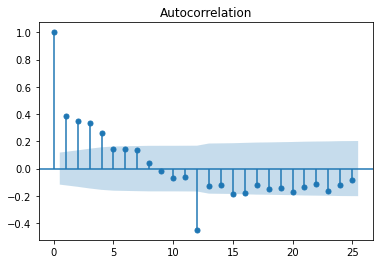

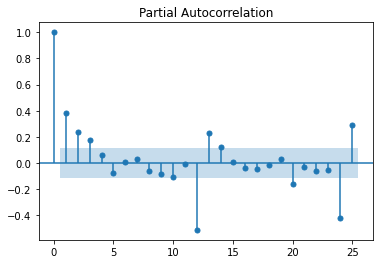

In [7]:
#求差分序列的自相关图ACF和偏自相关图PACF
sm.graphics.tsa.plot_acf(diff1.F1)
sm.graphics.tsa.plot_pacf(diff1.F1);

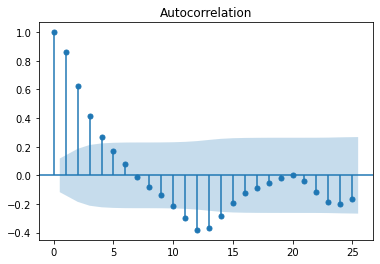

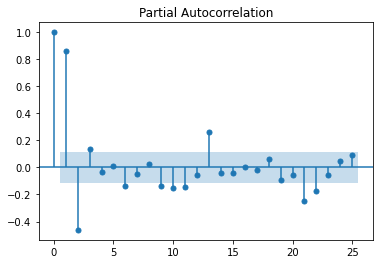

In [8]:
sm.graphics.tsa.plot_acf(diff1.F2)
sm.graphics.tsa.plot_pacf(diff1.F2);

In [9]:
sm.tsa.stattools.coint(data.F1,data.F2)

(-2.685956331613611,
 0.20467020627908233,
 array([-3.93626914, -3.35819706, -3.05974131]))

In [10]:
sm.tsa.stattools.coint(diff1.F1,diff1.F2)

(-4.759367372945497,
 0.00044476387006270026,
 array([-3.9364145 , -3.35827705, -3.05979664]))

In [24]:
orgMod = sm.tsa.VARMAX(diff1,freq='M',order=(3,0))
fitMod = orgMod.fit(maxiter=500)
print(fitMod.summary())
resid = fitMod.resid
result = {'fitMod':fitMod,'resid':resid}

                           Statespace Model Results                           
Dep. Variable:           ['F1', 'F2']   No. Observations:                  278
Model:                         VAR(3)   Log Likelihood                -499.885
                          + intercept   AIC                           1033.770
Date:                Thu, 19 May 2022   BIC                           1095.440
Time:                        13:52:57   HQIC                          1058.512
Sample:                    02-28-1999                                         
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.30, 0.04   Jarque-Bera (JB):       103.43, 291.63
Prob(Q):                        0.58, 0.84   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.69, 0.81   Skew:                       0.11, 0.26
Prob(H) (two-sided):            0.01,

In [22]:
# 原假设：无漂移（平稳），备择假设：有漂移（不平稳）
cusum = statsmodels.stats.diagnostic.breaks_cusumolsresid(resid.values)
"""
    sup_b : float
        The test statistic, maximum of absolute value of scaled cumulative OLS
        residuals.
    pval : float
        Probability of observing the data under the null hypothesis of no
        structural change, based on asymptotic distribution which is a Brownian
        Bridge
    crit: list
        The tabulated critical values, for alpha = 1%, 5% and 10%.
"""
cusum

(0.6885054328792821, 0.7302757199008029, [(1, 1.63), (5, 1.36), (10, 1.22)])

FEVD for F1
           F1        F2
0    1.000000  0.000000
1    0.997318  0.002682
2    0.996145  0.003855
3    0.988343  0.011657
4    0.962333  0.037667
5    0.937966  0.062034
6    0.915634  0.084366
7    0.898367  0.101633
8    0.886108  0.113892
9    0.877857  0.122143

FEVD for F2
           F1        F2
0    0.000482  0.999518
1    0.000277  0.999723
2    0.007781  0.992219
3    0.036293  0.963707
4    0.070790  0.929210
5    0.100858  0.899142
6    0.125037  0.874963
7    0.142908  0.857092
8    0.154974  0.845026
9    0.162008  0.837992


None


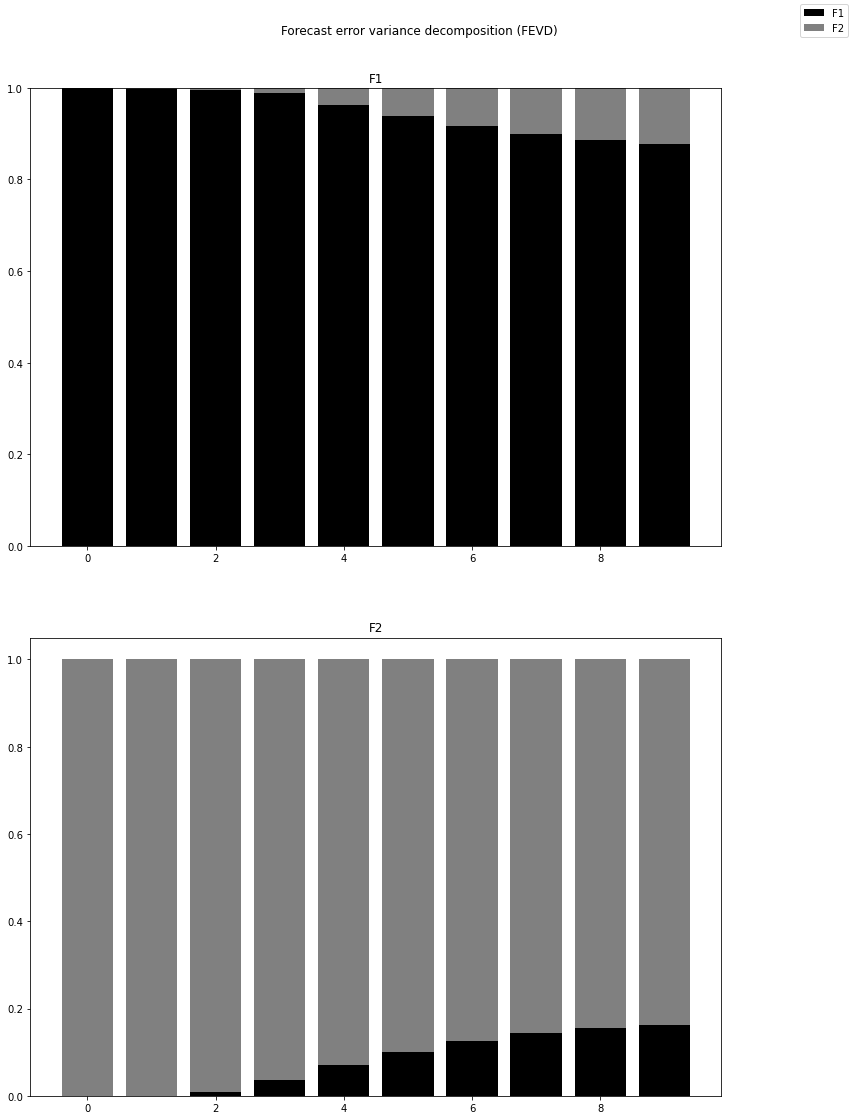

In [13]:
md = sm.tsa.VAR(diff1,freq='M')
re = md.fit(3)
fevd = re.fevd(10)
# 打印出方差分解的结果
print(fevd.summary())
# 画图
fevd.plot(figsize=(12, 16))
plt.show()